# Intro

## Requirements

In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import dice_ml

# Autoreload allows the notebook to dynamically load code: if we update some helper functions outside of the notebook, we do not need to reload the notebook.
%load_ext autoreload
%autoreload 2

# All auxiliary code is in ../src
# code taken from: https://github.com/data-mining-UniPI/teaching24/tree/main/src
import sys
sys.path.append("./src/")

# Set style for seaborn
sns.set_theme(style="darkgrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
import pickle

# Import the object using pickle
with open('prediction_datasets.pkl', 'rb') as f:
    sets = pickle.load(f)

print("Data has been imported from prediction_datasets.pkl")

Data has been imported from prediction_datasets.pkl


In [50]:

print("The datasets contained in the variable are:")
for key in sets:
    print(key)

The datasets contained in the variable are:
train_set
train_labels
validation_set
validation_labels
test_set
test_labels
train_set_scaled
validation_set_scaled
test_set_scaled


## Setting up the models

We use the models selected in the previous task.

In [51]:
from sklearn import tree

with open('best_decision_tree_model.pkl', 'rb') as f:
    dt = pickle.load(f)

print("Decision tree model has been imported from best_decision_tree_model.pkl")
print(dt)

Decision tree model has been imported from best_decision_tree_model.pkl
DecisionTreeClassifier(max_depth=7, min_samples_leaf=4, min_samples_split=4)


In [52]:
from tensorflow.keras.models import load_model

# Load the Keras model using the native Keras format
keras_model = load_model('keras_model.keras')
print("Keras model has been imported from keras_model.keras")

Keras model has been imported from keras_model.keras


# Tree model

## Feature importance

### Built-in feature importance

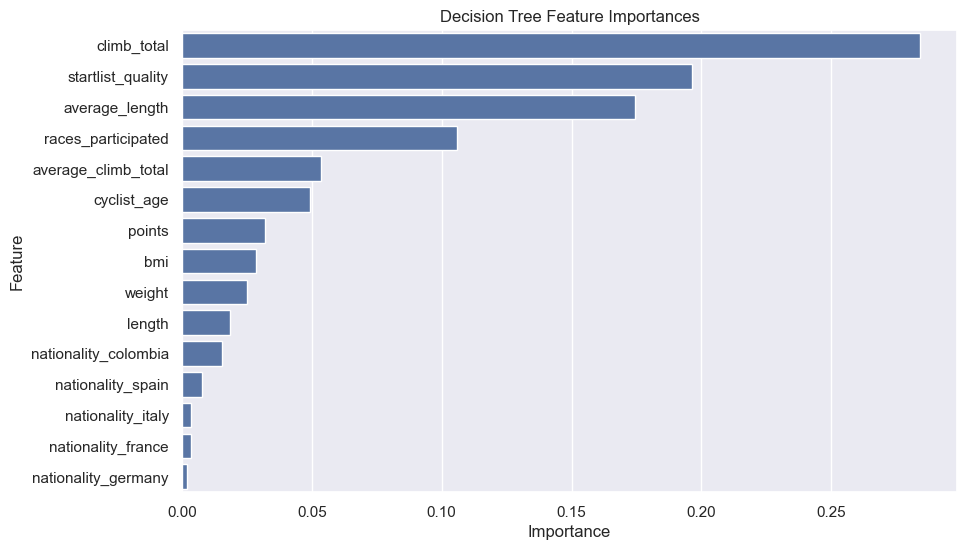

In [53]:
# Get feature importances from the Decision Tree
feature_importances = dt.feature_importances_
features = sets['train_set'].columns

# Create a DataFrame for visualization
fi_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Filter out features with importance less than 0.005
fi_df = fi_df[fi_df['Importance'] >= 0.001]

# Sort the DataFrame by importance
fi_df.sort_values('Importance', ascending=False, inplace=True)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=fi_df)
plt.title('Decision Tree Feature Importances')
plt.show()

### Using SHAP values

In [82]:
import shap

# Create the SHAP explainer
shap_explainer = shap.TreeExplainer(
    model=dt
)

# Generate SHAP values
shap_explanations = shap_explainer(sets['validation_set'].astype('float64'))
shap_explanations.shape

(18367, 75, 2)

In [84]:
import numpy as np

def compute_shap_feature_importance(shap_explanations):
    """
    Compute the mean absolute SHAP values for each feature.
    That is, the importance of each feature.
    """
    shap_values = shap_explanations.values
    mean_abs_shap_values = np.abs(shap_values).mean(axis=(0, 2))
    return mean_abs_shap_values

shap_feature_importances = compute_shap_feature_importance(shap_explanations)

# Print the feature importance
print("SHAP Feature Importances:", shap_feature_importances)
print("Number of SHAP Importances (should match number of features):", len(shap_feature_importances))

SHAP Feature Importances: [9.68940192e-03 5.14882035e-03 7.12203123e-02 4.91089061e-02
 2.22462324e-02 6.16847664e-03 6.27941408e-03 4.26509285e-02
 2.04933289e-02 6.21464518e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.95877945e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 9.06244454e-04 3.92625086e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.51116320e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+0

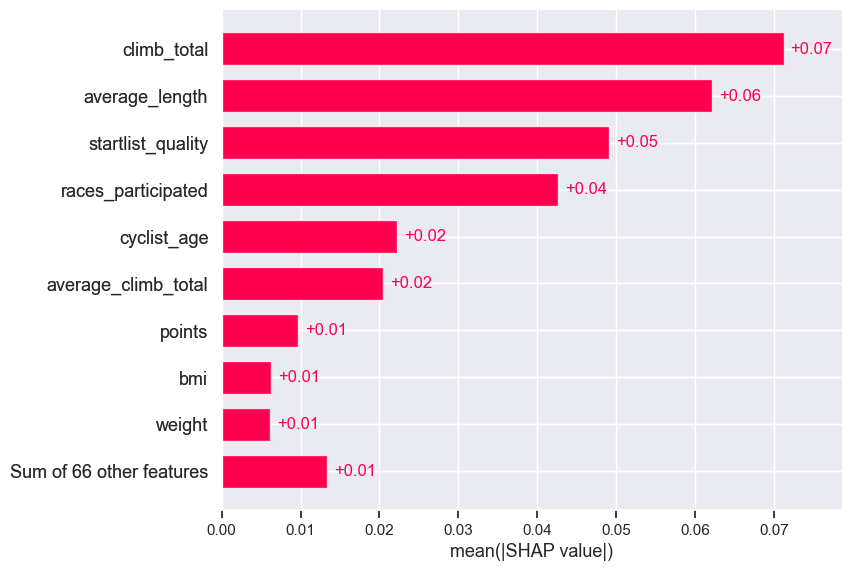

In [55]:
shap.plots.bar(shap_explanations[..., 1], max_display=10)

This SHAP summary plot explains how different features impact the model's prediction of whether a cyclist will finish in the top-20 for a race. 
This analysis provides insights into which features are most influential in the model's predictions and how they contribute to the decision-making process.

- **`average_length`**: Longer races tend to lower the likelihood of a cyclist finishing in the top-20, as indicated by the negative SHAP values for high `average_length`.
- **`startlist_quality`**: Higher quality start lists slightly increase the chances of finishing in the top-20, suggesting that stronger competition positively influences the outcome.
- **`races_participated`**: Cyclists who participate in more races are less likely to finish in the top-20, possibly due to fatigue or accumulated stress.
- **`climb_total`**: Higher total climbs reduce the probability of finishing in the top-20, indicating that tougher, more mountainous races negatively impact performance.
- **`cyclist_age`**: Younger cyclists have a higher likelihood of finishing in the top-20, as seen by the positive SHAP values for lower ages.


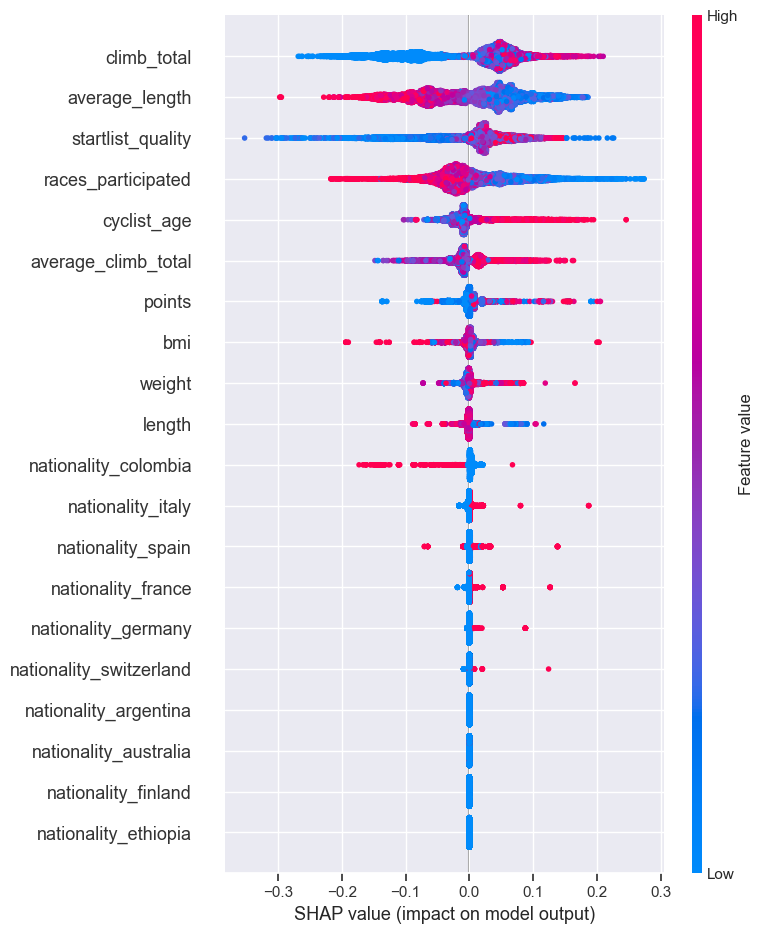

In [56]:
shap.summary_plot(shap_explanations.values[:, :, 0], sets['validation_set'].astype('float64'))

### Examples on instances: SHAP Waterfall Plot Analysis



Here we analyze a specific instance to understand how different features contribute to the model's prediction for that instance.

Waterfall plots generated by SHAP (SHapley Additive exPlanations) provide a detailed breakdown of how each feature contributes to the final prediction, making it easier to understand the influence of individual features.

This SHAP waterfall plot illustrates how each feature contributes to the model's prediction of whether a cyclist will finish in the top-20 for this specific race.

- **`average_length`**: With a SHAP value of -0.22, the long race distance (179855 meters) significantly decreases the likelihood of a top-20 finish.
- **`startlist_quality`**: A high-quality start list (594) further reduces the prediction by -0.15.
- **`races_participated`**: The cyclist's high participation in races (175) lowers the prediction by -0.07, suggesting potential fatigue.
- **`cyclist_age`**: The cyclist's age (28 years) slightly decreases the prediction by -0.02.
- **`average_climb_total`**: A high average climb total (2154 meters) contributes positively with a SHAP value of +0.02, indicating the cyclist might perform well in hilly races.
- Other features like `bmi`, `climb_total`, and `points` have smaller impacts, contributing either positively or negatively to the final prediction.

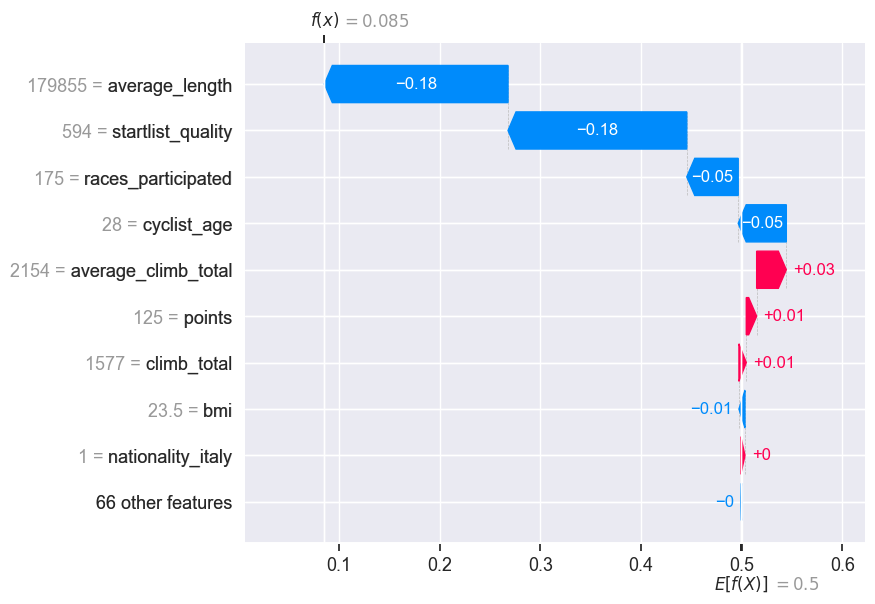

In [57]:
# Waterfall plot for the first instance and first class
shap.plots.waterfall(shap.Explanation(values=shap_explanations.values[0, :, 0], 
                                      base_values=shap_explanations.base_values[0, 0], 
                                      data=sets['validation_set'].astype('float64').iloc[0]))

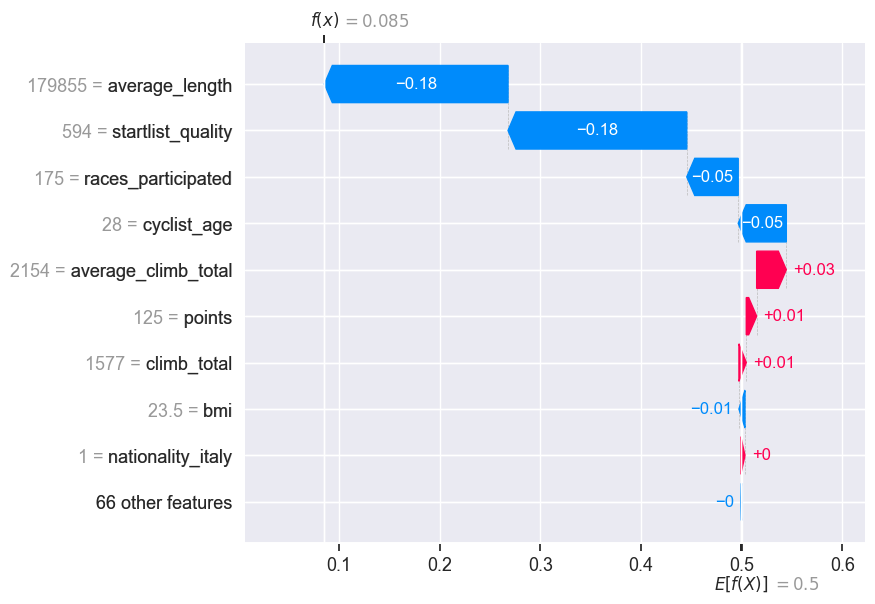

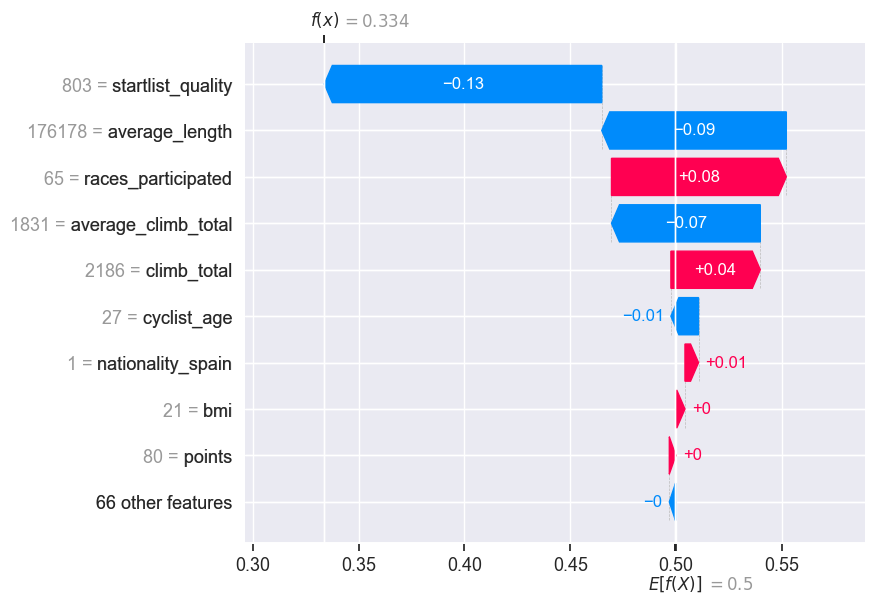

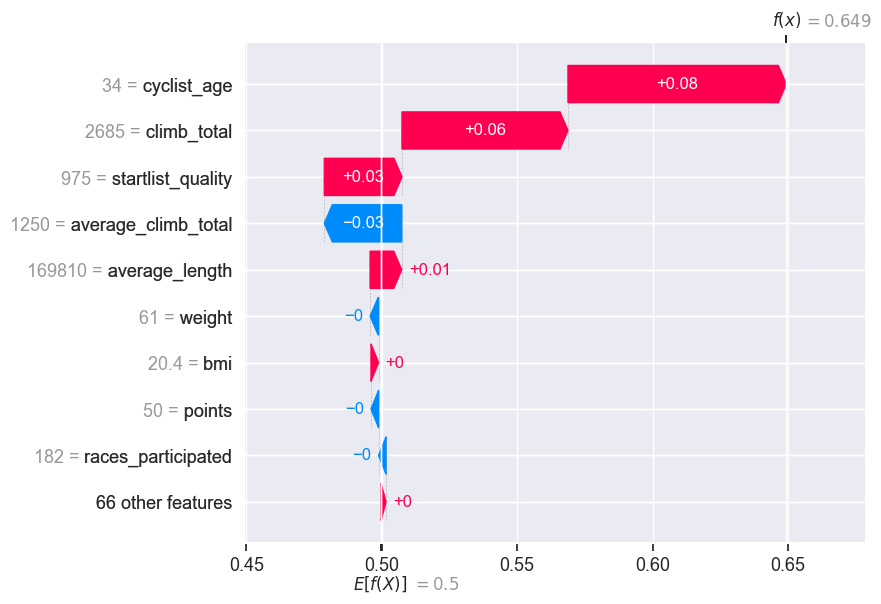

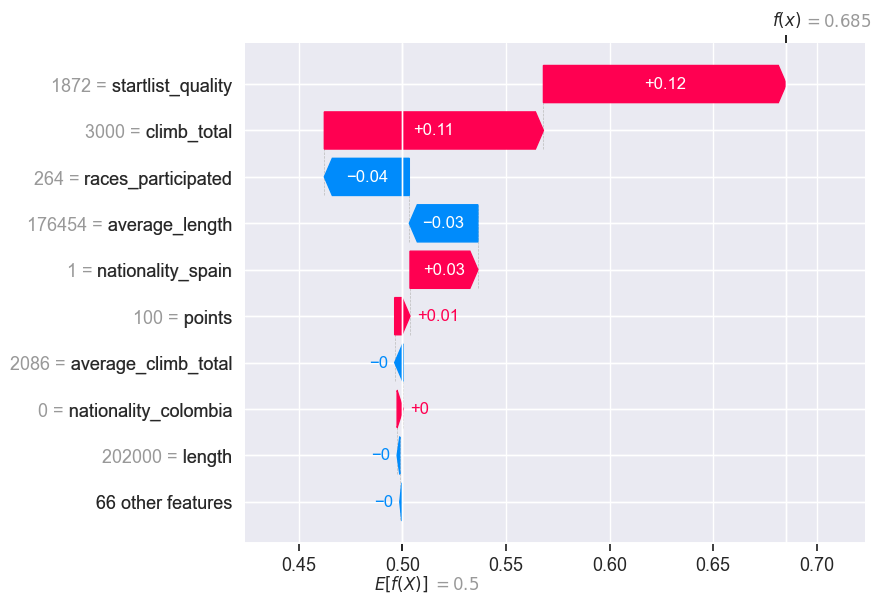

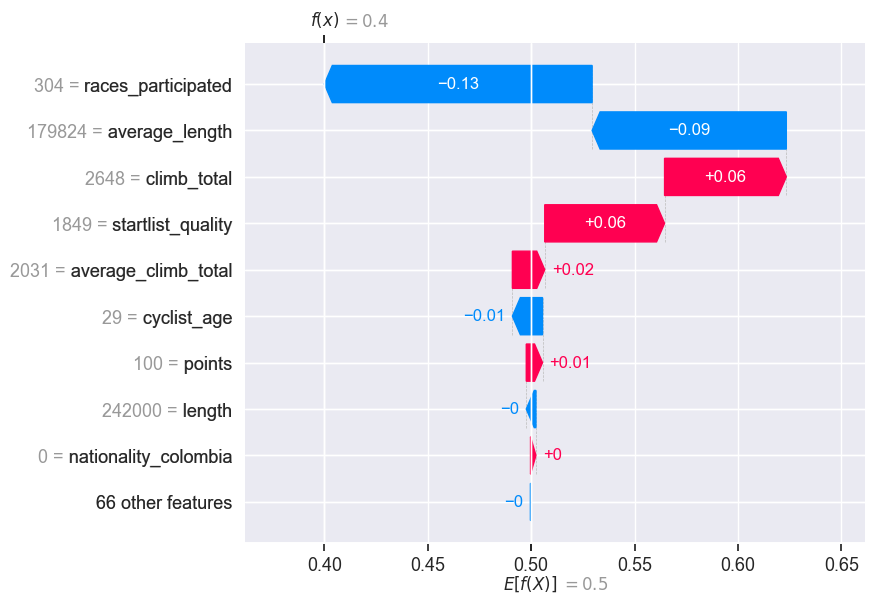

In [58]:
# Number of instances to plot
num_instances = 5  # Adjust this number as needed

# Loop through the instances and create waterfall plots
for i in range(num_instances):
    shap.plots.waterfall(shap.Explanation(values=shap_explanations.values[i, :, 0], 
                                          base_values=shap_explanations.base_values[i, 0], 
                                          data=sets['validation_set'].astype('float64').iloc[i]))
    plt.show()

## Rule Explaination

Decision trees are interpretable and transparent models, so it is easy to understand the decision-making: we simply need to look at the rules contained in each node of the tree.

On the other hand, for complex trees, it can be challenging to understand the overall logic.

In [90]:
# Tree depth
tree_depth = dt.get_depth()
print(f"Decision Tree Depth: {tree_depth}")

# Number of leaves (rules)
n_leaves = dt.get_n_leaves()
print(f"Number of Leaves (Rules): {n_leaves}")

Decision Tree Depth: 7
Number of Leaves (Rules): 126


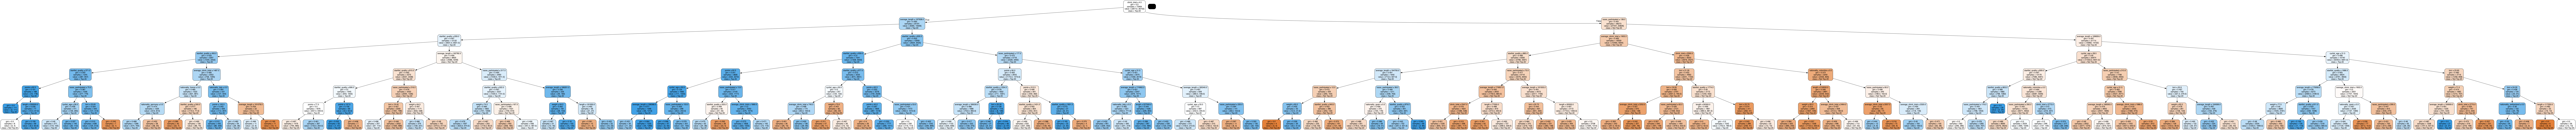

In [91]:
import os
os.environ["PATH"] += os.pathsep + '/opt/homebrew/Cellar/graphviz/12.2.1/bin'
import pydotplus
from IPython.display import Image
dot_data = tree.export_graphviz(dt, out_file=None,
                                feature_names=list(sets['train_set'].columns),
                                class_names=['Not Top-20', 'Top-20'],
                                filled=True, rounded=True,
                                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [61]:
# Extract the text representation of the tree
tree_rules = sklearn.tree.export_text(dt, feature_names=list(features))
print(tree_rules)

|--- climb_total <= 4.50
|   |--- average_length <= 167928.00
|   |   |--- startlist_quality <= 659.00
|   |   |   |--- startlist_quality <= 493.50
|   |   |   |   |--- startlist_quality <= 371.00
|   |   |   |   |   |--- points <= 62.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- points >  62.50
|   |   |   |   |   |   |--- length <= 200500.00
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- length >  200500.00
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- startlist_quality >  371.00
|   |   |   |   |   |--- races_participated <= 75.50
|   |   |   |   |   |   |--- cyclist_age <= 26.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- cyclist_age >  26.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- races_participated >  75.50
|   |   |   |   |   |   |--- bmi <= 23.65
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- bmi >  23.65
|   |   |   |   |   |   |   |--- cla

Let's also see an example of the classification of a specific instance using the tree model.

In [62]:
def get_rule_path(tree, feature_names, instance):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != sklearn.tree._tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    path = []
    node_indicator = tree.decision_path(instance)
    leaf_id = tree.apply(instance)
    
    for node_id in range(node_indicator.shape[1]):
        if node_indicator[0, node_id]:
            if leaf_id[0] == node_id:
                path.append(f"Leaf node {node_id} reached, prediction: {tree_.value[node_id]}")
            else:
                threshold = tree_.threshold[node_id]
                if instance[0, tree_.feature[node_id]] <= threshold:
                    path.append(f"{feature_name[node_id]} <= {threshold}")
                else:
                    path.append(f"{feature_name[node_id]} > {threshold}")
    return path

# Loop through the first 5 instances and get the rule path for each
for i in range(5):
    instance = sets['validation_set'].iloc[i]
    instance_reshaped = instance.values.reshape(1, -1)
    prediction = dt.predict(instance_reshaped)
    print(f"The predicted class for instance {i} is: {prediction[0]}")

    # Get the rule path for the selected instance
    rule_path = get_rule_path(dt, features, instance_reshaped)
    print(f"Rules followed for instance {i}:")
    for rule in rule_path:
        print(rule)
    print("\n")

The predicted class for instance 0 is: 1
Rules followed for instance 0:
climb_total > 4.5
races_participated > 138.5
average_length > 169839.0
cyclist_age <= 31.5
startlist_quality <= 1686.5
average_length > 175958.0
startlist_quality <= 811.0
Leaf node 227 reached, prediction: [[0.08527132 0.91472868]]


The predicted class for instance 1 is: 1
Rules followed for instance 1:
climb_total > 4.5
races_participated <= 138.5
average_climb_total <= 1905.5
startlist_quality <= 885.0
average_length > 164700.0
races_participated > 38.5
startlist_quality <= 879.5
Leaf node 142 reached, prediction: [[0.3337766 0.6662234]]


The predicted class for instance 2 is: 0
Rules followed for instance 2:
climb_total > 4.5
races_participated > 138.5
average_length <= 169839.0
cyclist_age > 28.5
races_participated <= 313.5
cyclist_age > 31.5
average_climb_total <= 1986.0
Leaf node 211 reached, prediction: [[0.64934165 0.35065835]]


The predicted class for instance 3 is: 0
Rules followed for instance 3:
cli

/Users/ema/projects/dm-project/venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/ema/projects/dm-project/venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/ema/projects/dm-project/venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/ema/projects/dm-project/venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/ema/projects/dm-project/venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifi

## Conterfactual Instances

TODO: conterfactuals by traversing the tree in the opposite direction of the prediction.

In [63]:
# Prepare the data for DiCE
# DiCE requires the data in specific format
ts = sets['train_set']
tl = sets['train_labels']
dice_data = pd.concat([ts, tl], axis=1)
dice_data.reset_index(drop=True, inplace=True)
dice_data = dice_data.astype('float64')
# Define Dice Data object
dice_dataset = dice_ml.Data(dataframe=dice_data, continuous_features=features.tolist(), outcome_name=sets['train_labels'].name)

# Define the model for DiCE
dice_model = dice_ml.Model(model=dt, backend="sklearn")

# Create a DiCE explainer
explainer_dice = dice_ml.Dice(dice_dataset, dice_model, method="random")

We select a single instance from the test set as input for generating counterfactual explanations. 
Counterfactuals will show minimal changes needed to change the model's prediction.

In [64]:
# Choose an instance from test set to explain
query_instance = ts.iloc[[0]]

# Generate counterfactual explanations
dice_exp = explainer_dice.generate_counterfactuals(query_instance, total_CFs=3, desired_class="opposite")
dice_exp.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

Query instance (original outcome : 0)


points    length  climb_total  startlist_quality  cyclist_age  weight  \
0   225.0  196200.0       1652.0              727.0         24.0    71.0   

         bmi  races_participated  average_climb_total  average_length  ...  \
0  20.299999                53.0               2143.0        192015.0  ...   

   nationality_sweden  nationality_switzerland  nationality_ukraine  \
0                 0.0                      0.0                  0.0   

   nationality_united states  nationality_uruguay  nationality_uzbekistan  \
0                        0.0                  0.0                     0.0   

   nationality_venezuela  nationality_yugoslavia  nationality_zimbabwe  \
0                    0.0                     0.0                   0.0   

   is_top_20  
0          0  

[1 rows x 76 columns]


Diverse Counterfactual set (new outcome: 1.0)


points length climb_total startlist_quality cyclist_age weight        bmi  \
0      -      -           -                 -           -      -  21.000002   
1      -      -           -                 -           -      -       23.7   
2      -      -           -                 -           -      -       22.6   

  races_participated average_climb_total average_length  ...  \
0                  -               282.6              -  ...   
1                  -                   -              -  ...   
2                  -                   -              -  ...   

  nationality_sweden nationality_switzerland nationality_ukraine  \
0                  -                       -                   -   
1                  -                       -                   -   
2                  -                       -                   -   

  nationality_united states nationality_uruguay nationality_uzbekistan  \
0                         -                   -                      -   
1                         -                   -                      -   
2                         -                 0.9                      -   

  nationality_venezuela nationality_yugoslavia nationality_zimbabwe is_top_20  
0                     -                      -                    -         1  
1                     -                      -                    -         1  
2                     -                      -                    -         1  

[3 rows x 76 columns]

## Fidelity and Complexity Analysis

## Fidelity

Fidelity measures how well the explanations reflect the original model's behavior.
Since we are now evaluating a tree model (which is an interpretable model), we can directly compare the rules generated by the tree model with the SHAP values.

In [85]:
# DataFrame containing the comparison
importance_comparison = pd.DataFrame({
    'Feature': features,  # List of feature names
    'Built-in Importance': feature_importances,  # Importance values from your model
    'SHAP Importance': compute_shap_feature_importance(shap_explanations)  # Computed SHAP importances
}).set_index('Feature')

importance_comparison

Built-in Importance  SHAP Importance
Feature                                                     
points                             0.031880         0.009689
length                             0.018591         0.005149
climb_total                        0.284238         0.071220
startlist_quality                  0.196546         0.049109
cyclist_age                        0.049449         0.022246
...                                     ...              ...
nationality_uruguay                0.000000         0.000000
nationality_uzbekistan             0.000000         0.000000
nationality_venezuela              0.000000         0.000000
nationality_yugoslavia             0.000000         0.000000
nationality_zimbabwe               0.000000         0.000000

[75 rows x 2 columns]

Since the 2 values have different scales, we normalized the values to make them comparable.
As expected, we observe that the SHAP importance has approximately the same results found by the built-in importance.

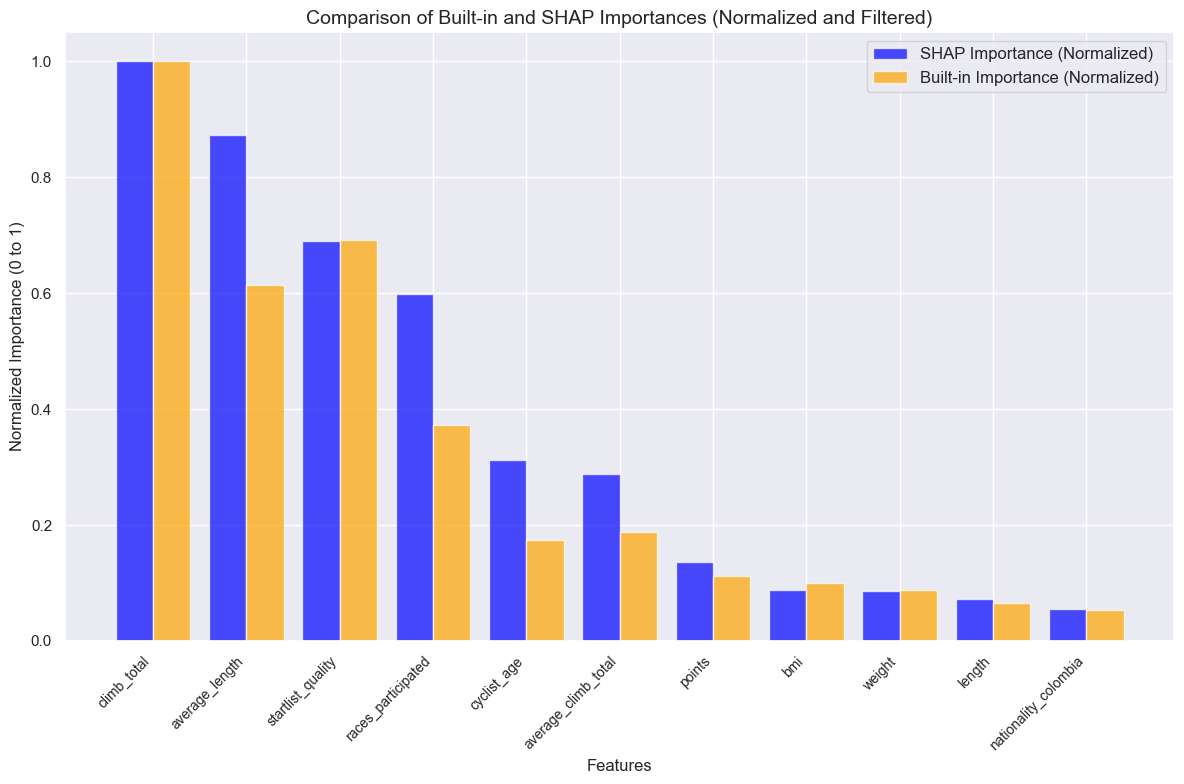

In [89]:
# Step 1: Filter out features where both importances are less than 0.01
filtered_comparison = importance_comparison[
    (importance_comparison['SHAP Importance'] >= 0.01) |
    (importance_comparison['Built-in Importance'] >= 0.01)
]

# Step 2: Sort features by SHAP Importance for better visualization
importance_comparison_sorted = filtered_comparison.sort_values('SHAP Importance', ascending=False)

# Step 3: Extract sorted data for visualization
features_sorted = importance_comparison_sorted.index
built_in_importance = importance_comparison_sorted['Built-in Importance']
shap_importance = importance_comparison_sorted['SHAP Importance']

# Step 4: Normalize both importance metrics to a common scale (0 to 1)
built_in_importance_normalized = built_in_importance / built_in_importance.max()
shap_importance_normalized = shap_importance / shap_importance.max()

# Step 5: Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Set bar width
bar_width = 0.4
x = np.arange(len(features_sorted))

# Plot the normalized SHAP importance
ax.bar(x - bar_width / 2, shap_importance_normalized, bar_width, label='SHAP Importance (Normalized)', color='blue', alpha=0.7)

# Plot the normalized Built-in importance
ax.bar(x + bar_width / 2, built_in_importance_normalized, bar_width, label='Built-in Importance (Normalized)', color='orange', alpha=0.7)

# Add labels, title, and legend
ax.set_xlabel("Features", fontsize=12)
ax.set_ylabel("Normalized Importance (0 to 1)", fontsize=12)
ax.set_title("Comparison of Built-in and SHAP Importances (Normalized and Filtered)", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(features_sorted, rotation=45, ha="right", fontsize=10)
ax.legend(fontsize=12)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### Complexity

Complexity assesses how easily a human can understand the explanations.
In our case, we are evaluating a tree, so we can measure complexity by the depth of the tree or the number of rules.

If the tree has too many rules, it can be harder to interpret the global reasoning of the model.
A tree with too many rules can be considered harder to interpret as a 

In [ ]:
# Tree depth
tree_depth = dt.get_depth()
print(f"Decision Tree Depth: {tree_depth}")

# Number of leaves (rules)
n_leaves = dt.get_n_leaves()
print(f"Number of Leaves (Rules): {n_leaves}")

Understanding why the model made a certain decision on a specific instance is however less complex: the tree has a depth of 7, so the explaination can be provided as a set of 7 rules:

In [96]:
print(rule_path)

['climb_total > 4.5', 'races_participated > 138.5', 'average_length > 169839.0', 'cyclist_age <= 31.5', 'startlist_quality > 1686.5', 'average_climb_total > 1902.0', 'races_participated > 299.5', 'Leaf node 235 reached, prediction: [[0.4 0.6]]']


# Evaluation of neural network model

Explaining neural networks is more challenging due to their black-box nature.

In [61]:
K = 300  # Number of samples
sets['train_set_scaled_sliced'] = sets['train_set_scaled'][:K].astype('float64')
sets['validation_set_scaled_sliced'] = sets['validation_set_scaled'][:K].astype('float64')
sets['train_labels_sliced'] = sets['train_labels'][:K].astype('float64')
sets['validation_labels_sliced'] = sets['validation_labels'][:K].astype('float64')
sets.keys()

dict_keys(['train_set', 'train_labels', 'validation_set', 'validation_labels', 'test_set', 'test_labels', 'train_set_scaled', 'validation_set_scaled', 'test_set_scaled', 'train_set_scaled_sliced', 'validation_set_scaled_sliced', 'train_labels_sliced', 'validation_labels_sliced'])

/Users/ema/projects/dm-project/venv/lib/python3.10/site-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/Users/ema/projects/dm-project/venv/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_1
Received: inputs=['Tensor(shape=(300, 75))']
  warnings.warn(msg)
/Users/ema/projects/dm-project/venv/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_1
Received: inputs=['Tensor(shape=(600, 75))']
  warnings.

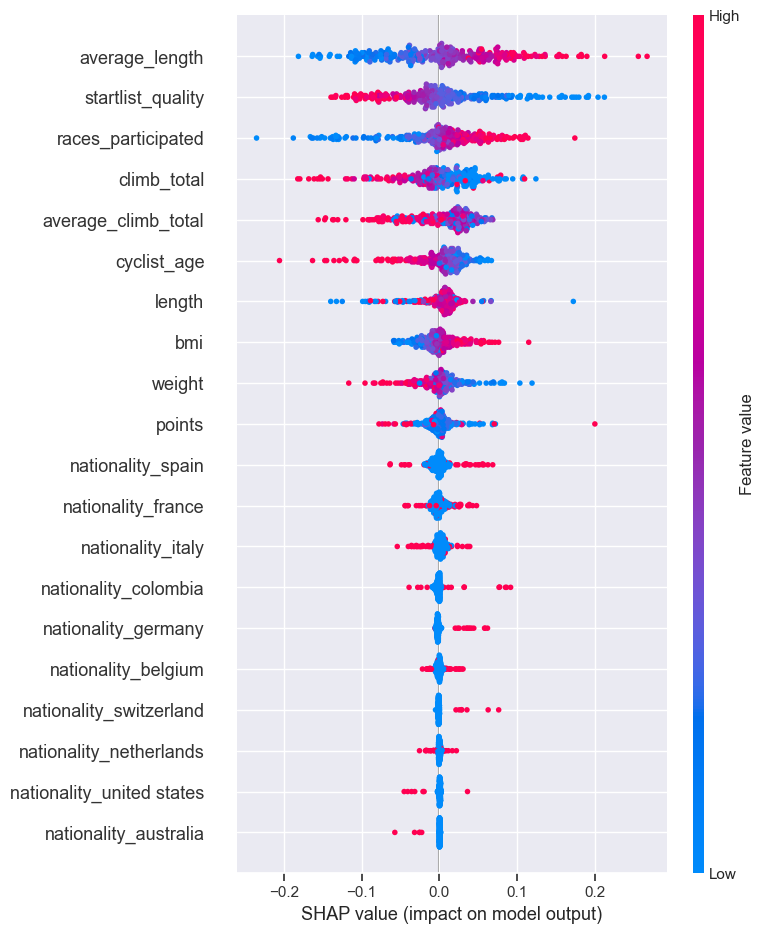

In [110]:
explainer_nn = shap.DeepExplainer(keras_model, sets['validation_set_scaled_sliced'])
shap_values_nn = explainer_nn.shap_values(sets['validation_set_scaled_sliced'].values)
features = sets['train_set'].columns
shap.summary_plot(shap_values_nn[:, :, 0], sets['validation_set_scaled_sliced'].astype('float64'))

## SHAP Summary Plot Analysis

This SHAP summary plot explains how different features impact the model's prediction of whether a cyclist will finish in the top-20 for a race. 

- **`average_length`**: Longer races tend to lower the likelihood of a cyclist finishing in the top-20, as indicated by the negative SHAP values for high `average_length`.
- **`startlist_quality`**: Higher quality start lists slightly increase the chances of finishing in the top-20, suggesting that stronger competition positively influences the outcome.
- **`races_participated`**: Cyclists who participate in more races are less likely to finish in the top-20, possibly due to fatigue or accumulated stress.
- **`climb_total`**: Higher total climbs reduce the probability of finishing in the top-20, indicating that tougher, more mountainous races negatively impact performance.
- **`cyclist_age`**: Younger cyclists have a higher likelihood of finishing in the top-20, as seen by the positive SHAP values for lower ages.

This analysis provides insights into which features are most influential in the model's predictions and how they contribute to the decision-making process.

In [ ]:

# Summary plot for the first class
shap.summary_plot(shap_explanations.values[:, :, 0], validation_set_scaled_sampled)



## Examples on instances: SHAP Waterfall Plot Analysis

Here we analyze a specific instance to understand how different features contribute to the model's prediction for that instance.

This SHAP waterfall plot illustrates how each feature contributes to the model's prediction of whether a cyclist will finish in the top-20 for this specific race.

- **`average_length`**: With a SHAP value of -0.22, the long race distance (179855 meters) significantly decreases the likelihood of a top-20 finish.
- **`startlist_quality`**: A high-quality start list (594) further reduces the prediction by -0.15.
- **`races_participated`**: The cyclist's high participation in races (175) lowers the prediction by -0.07, suggesting potential fatigue.
- **`cyclist_age`**: The cyclist's age (28 years) slightly decreases the prediction by -0.02.
- **`average_climb_total`**: A high average climb total (2154 meters) contributes positively with a SHAP value of +0.02, indicating the cyclist might perform well in hilly races.
- Other features like `bmi`, `climb_total`, and `points` have smaller impacts, contributing either positively or negatively to the final prediction.

In [ ]:
# Waterfall plot for the first instance and first class
shap.plots.waterfall(shap.Explanation(values=shap_explanations.values[0, :, 0], 
                                      base_values=shap_explanations.base_values[0, 0], 
                                      data=sets['validation_set'].astype('float64').iloc[0]))

In [ ]:
# Number of instances to plot
num_instances = 5  # Adjust this number as needed

# Loop through the instances and create waterfall plots
for i in range(num_instances):
    shap.plots.waterfall(shap.Explanation(values=shap_explanations.values[i, :, 0], 
                                          base_values=shap_explanations.base_values[i, 0], 
                                          data=sets['validation_set'].astype('float64').iloc[i]))
    plt.show()

# Surrogate Model for the Neural Network

In [ ]:
import interpret
from tqdm import tqdm

interpret.set_visualize_provider(interpret.provider.InlineProvider())



explaination_algo = interpret.blackbox.LimeTabular(keras_model, sets['train_set_scaled_sliced'])


In [ ]:
LIME_explaination = np.array([np.array(e["scores"]) for e in tqdm(explaination_algo.explain_local(sets['train_set_scaled_sliced'], sets['train_labels_sliced'] )._internal_obj["specific"])])

In [ ]:
metric = "f1-score"
corruption_validation_lime = pd.DataFrame([
    (feature, noise_magnitude, validations_by_feature_and_noise[(feature, noise_magnitude)]["weighted avg"][metric], "lime")
    for feature, noise_magnitude in validations_by_feature_and_noise
    ],
    columns=["feature", "noise_magnitude", "performance", "algorithm"]
)
corruption_validation_lime["difference"] = corruption_validation_lime["performance"] - validation["weighted avg"][metric]

corruption_validation = pd.concat((corruption_validation, corruption_validation_lime))
corruption_validation_lime